# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the 为SVM实现完全矢量化的损失函数
- implement the fully-vectorized expression for its **analytic gradient**实现其完全矢量化的解析梯度
- **check your implementation** using numerical gradient 使用数值梯度检查您的实施
- use a validation set to **tune the learning rate and regularization** strength 使用验证集来调整学习率和正则化
- **optimize** the loss function with **SGD** 使用SGD优化loss函数
- **visualize** the final learned weights 可视化最终的学习权重


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [13]:
# Load the raw CIFAR-10 data. 读入cifar10 数据集
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
# 清理变量防止多次读入有内存问题
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


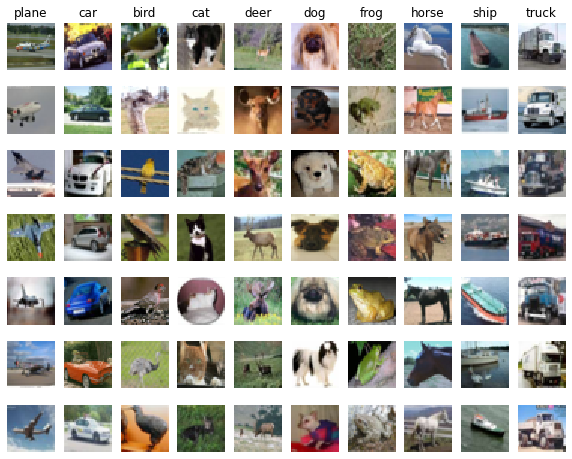

In [14]:
# Visualize some examples from the dataset.可视化一些示例
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [15]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
# 将数据拆分为训练 验证 测试集合
#创建一个小的开发集作为训练数据的子集，用于开发可以更快运行代码
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# # Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
# 将数据拆分为训练 验证 测试集合
#创建一个小的开发集作为训练数据的子集，用于开发可以更快运行代码
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# 
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [16]:
# Preprocessing: reshape the image data into rows
# 数据预处理 将32*32*3整理为一行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


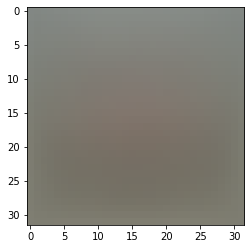

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [17]:
# Preprocessing: subtract the mean image
# 数据预处理： 减去平均图像
# first: compute the image mean based on the training data
# 第一步 计算训练集图像均值
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# 增加一维bias维度，使得svm只需要优化一个权重矩阵W
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [23]:
X_dev,y_dev

(array([[  94.35810204,   78.01826531,   87.52608163, ...,   58.13804082,
           71.60042857,    1.        ],
        [ 124.35810204,  119.01826531,  122.52608163, ...,  -46.86195918,
          -35.39957143,    1.        ],
        [ -34.64189796,  -50.98173469,  -70.47391837, ...,  -39.86195918,
          -45.39957143,    1.        ],
        ...,
        [-101.64189796, -108.98173469, -111.47391837, ...,  -71.86195918,
          -72.39957143,    1.        ],
        [-123.64189796, -130.98173469, -124.47391837, ...,  -16.86195918,
           -2.39957143,    1.        ],
        [  63.35810204,   58.01826531,   59.52608163, ...,  -53.86195918,
          -48.39957143,    1.        ]]),
 array([3, 1, 6, 7, 4, 2, 7, 2, 1, 8, 6, 3, 4, 8, 3, 9, 8, 9, 1, 9, 8, 4,
        7, 3, 6, 3, 6, 5, 2, 4, 0, 0, 5, 8, 0, 2, 0, 1, 6, 8, 8, 0, 4, 3,
        3, 2, 3, 9, 3, 4, 0, 1, 4, 2, 6, 6, 6, 2, 0, 6, 3, 8, 6, 9, 3, 1,
        7, 0, 3, 2, 6, 6, 3, 2, 7, 4, 3, 1, 1, 9, 5, 4, 3, 3, 3, 4, 1, 4,
     

In [46]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0001)
print('loss: %f' % (loss, ))

loss: 9.137987


In [47]:
grad

array([[ 7.67649078e-01, -2.48443796e+01,  1.41775417e+01, ...,
        -6.72387823e+00, -1.68497296e+01, -2.95997189e+01],
       [-1.54352421e+01, -2.40123469e+01,  1.10987122e+01, ...,
        -8.74040185e+00, -2.70682922e+01, -3.19319267e+01],
       [-4.65857736e+01, -2.92447837e+01,  1.98233053e+01, ...,
        -8.11357378e+00, -4.51924173e+01, -3.63974719e+01],
       ...,
       [-6.73386761e-01, -1.55643918e+01, -1.98284735e+00, ...,
        -1.55490369e+01,  1.83791343e-01, -1.41489860e+01],
       [-2.42388292e+01, -1.65679143e+01,  2.20792285e+00, ...,
         2.33879057e+00, -1.71956069e+01, -1.51246106e+01],
       [-6.80000261e-02,  1.99999966e-01, -1.80000041e-01, ...,
        -2.19999876e-02, -1.60000050e-02,  4.41999997e-01]])

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:
从上面的函数返回的`grad`现在都为零。 推导并实现SVM成本函数的梯度，并在函数svm_loss_naive中内嵌实现。 您会发现将新代码插入现有函数中会很有帮助。

为了检查您是否正确正确地实现了梯度，可以对损失函数的梯度进行数字估计，并将数字估计与您计算出的梯度进行比较。 我们提供了为您执行此操作的代码：

In [48]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 13.663573 analytic: 13.663573, relative error: 2.963439e-12
numerical: -9.962684 analytic: -9.962684, relative error: 3.358353e-11
numerical: -13.985180 analytic: -13.985180, relative error: 7.188088e-12
numerical: -56.695168 analytic: -56.695168, relative error: 7.237689e-12
numerical: 43.199898 analytic: 43.199898, relative error: 1.496995e-12
numerical: 8.120439 analytic: 8.120439, relative error: 1.846152e-11
numerical: -13.383027 analytic: -13.383027, relative error: 2.001732e-12
numerical: 20.237568 analytic: 20.237568, relative error: 2.035876e-11
numerical: -7.457064 analytic: -7.457064, relative error: 3.043679e-11
numerical: -36.151060 analytic: -36.151060, relative error: 1.800814e-11
numerical: 11.660004 analytic: 11.660004, relative error: 1.914290e-11
numerical: 16.440151 analytic: 16.440151, relative error: 2.739930e-12
numerical: -14.930244 analytic: -14.930244, relative error: 6.139217e-14
numerical: 23.763663 analytic: 23.763663, relative error: 1.584893e-1

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

有时gradcheck中的尺寸可能会不完全匹配。 造成这种差异的原因是什么？ 这是引起关注的原因吗？ 一个简单的示例在一个维度上可能会导致梯度检查失败？ 如何改变保证金对这种情况发生频率的影响？ *提示：SVM丢失功能严格来说是不可区分的*
$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [58]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.137987e+00 computed in 0.117703s
Vectorized loss: 9.137987e+00 computed in 0.003989s
difference: 0.000000


In [59]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.105715s
Vectorized loss and gradient: computed in 0.003990s
difference: 0.000000


### Stochastic Gradient Descent
现在，我们有了损耗，梯度和梯度与数值梯度匹配的矢量化高效表达式。 因此，我们准备进行SGD随机梯度下降，以最大程度地减少损失。
We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [60]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 789.866596
iteration 100 / 1500: loss 289.553563
iteration 200 / 1500: loss 109.007484
iteration 300 / 1500: loss 43.452897
iteration 400 / 1500: loss 18.861691
iteration 500 / 1500: loss 10.337672
iteration 600 / 1500: loss 7.135947
iteration 700 / 1500: loss 6.099569
iteration 800 / 1500: loss 4.970931
iteration 900 / 1500: loss 4.687408
iteration 1000 / 1500: loss 5.335958
iteration 1100 / 1500: loss 4.975001
iteration 1200 / 1500: loss 5.143209
iteration 1300 / 1500: loss 5.331948
iteration 1400 / 1500: loss 4.820979
That took 6.269718s


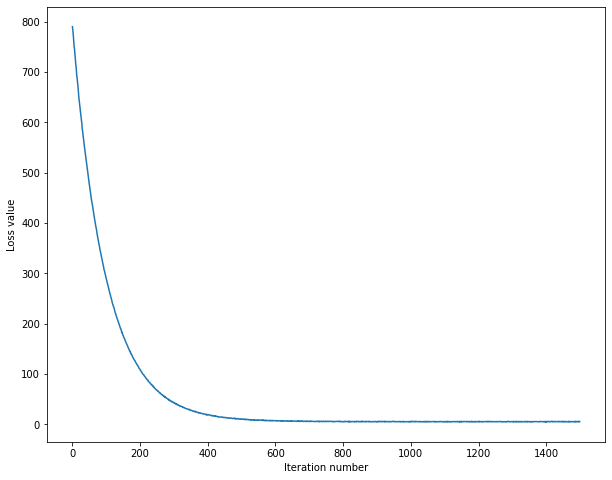

In [61]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [62]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.362367
validation accuracy: 0.371000


In [69]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
#使用验证集调整超参数（正则化强度和学习率）。你应该尝试不同的学习范围学习速率和正则化强度；
#如果你小心的话，你应该能够在验证集上得到的分类精度约为0.39。
#注意：在超参数搜索期间，您可能会看到运行时/溢出警告。这可能是由极端值引起的，不是错误。
#结果是字典映射元组的形式（学习率，正则化强度）到形式的元组（训练精确度、验证精确度）。
#准确度只是分数正确分类的数据点。
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
#编写代码，通过调整验证来选择最佳的超参数设置。
#对于每一个超参数组合，在训练集上训练一个线性支持向量机，在训练集和验证集上计算其精度，
#以及将这些数字存储在结果字典中。此外，储存最佳值中的验证精度以及实现此目标的LinearSVM对象
# 
#提示：在开发应用程序时，应该为num_iters使用一个小值验证代码，使支持向量机不需要花太多时间来训练；
#如果你很自信你的验证代码能够工作，您应该重新运行验证代码，为num_iters选择数值较大的值#
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-8, 5e-7]
regularization_strengths = [5e4, 1e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 1527.670618
iteration 100 / 1500: loss 1248.388320
iteration 200 / 1500: loss 1021.613114
iteration 300 / 1500: loss 834.207988
iteration 400 / 1500: loss 685.600735
iteration 500 / 1500: loss 559.091453
iteration 600 / 1500: loss 458.572727
iteration 700 / 1500: loss 376.644982
iteration 800 / 1500: loss 309.230939
iteration 900 / 1500: loss 253.717902
iteration 1000 / 1500: loss 208.022111
iteration 1100 / 1500: loss 171.421446
iteration 1200 / 1500: loss 141.405870
iteration 1300 / 1500: loss 115.865122
iteration 1400 / 1500: loss 96.151022
iteration 0 / 1500: loss 3123.022811
iteration 100 / 1500: loss 2089.769123
iteration 200 / 1500: loss 1401.129748
iteration 300 / 1500: loss 938.788037
iteration 400 / 1500: loss 631.200628
iteration 500 / 1500: loss 423.341053
iteration 600 / 1500: loss 285.601541
iteration 700 / 1500: loss 192.656224
iteration 800 / 1500: loss 130.704998
iteration 900 / 1500: loss 89.180756
iteration 1000 / 1500: loss 62.386330
iterati

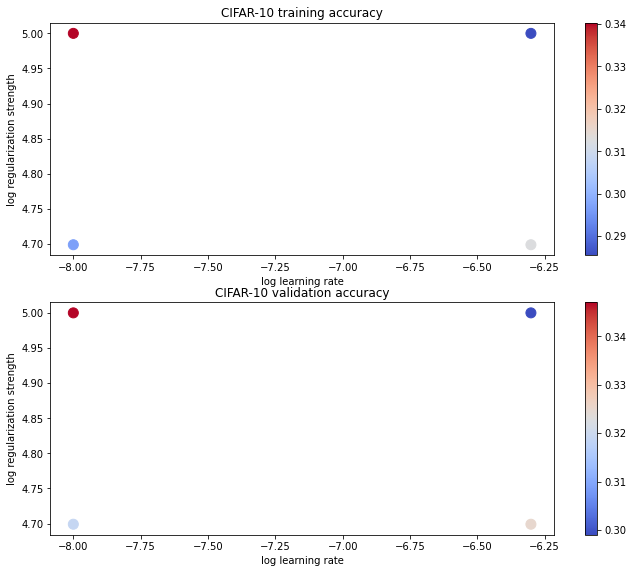

In [70]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [71]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.339000


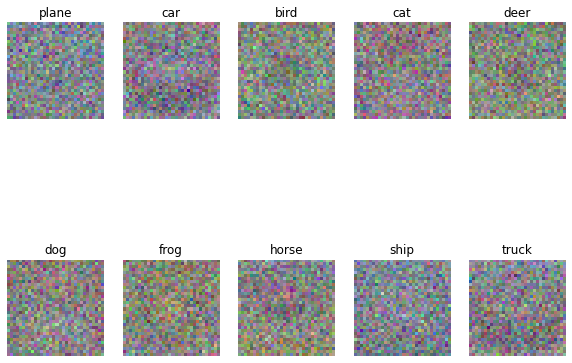

In [72]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
